In [3]:

!pip3 install wordninja==2.0.0             # for splitting joined words
!pip3 install scikit-learn==0.22.2         # for one-hot encoding
!pip3 install lime==0.2.0                  # for explaining model predictions
!pip3 install tensorflow

     |████████████████████████████████| 541 kB 431 kB/s eta 0:00:01
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541553 sha256=b8a1bea3bef3d36a15d91f10b9d90929ef749c981ea8c7eaf64bcb4f1efb585e
  Stored in directory: /Users/chenxinda/Library/Caches/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
     |████████████████████████████████| 7.1 MB 409 kB/s eta 0:00:01     |█▋                              | 358 kB 409 kB/s eta 0:00:17     |███████████████▌                | 3.5 MB 3.9 MB/s eta 0:00:01     |██████████████████████████████  | 6.7 MB 409 kB/s eta 0:00:02
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
     |████████████████████████████████| 274 kB 424 kB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 664 kB/s eta 0:00:01
  Created wheel for lime: filename=l

In [5]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import tensorflow as tf
# Check if any GPU is detected
print("Is GPU available: ", tf.test.is_gpu_available())
print("GPU(s) found: ")
print(tf.config.experimental.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available:  False
GPU(s) found: 
[]


In [59]:
data_path = os.getcwd().replace('script', 'data')
print(data_path)
data = pd.read_csv(data_path + '/train.csv')

/Users/chenxinda/Downloads/COMP__3359__GROUP8-main 2/data


In [60]:
data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [61]:
glove_path = data_path + '/glove.6B.50d.txt'
glove_path

'/Users/chenxinda/Downloads/COMP__3359__GROUP8-main 2/data/glove.6B.50d.txt'

In [72]:
data=data.sample(frac=0.1, replace=False, random_state=1).reset_index().drop(columns = ["index"])

In [73]:
from string import punctuation
from collections import defaultdict
import numpy as np

def load_embedding_from_disks(glove_filename, with_indexes=True):
    """
    Read a GloVe txt file. If `with_indexes=True`, we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    
    with open(glove_filename, 'r') as glove_file:
        for (i, line) in enumerate(glove_file):
            
            split = line.split(' ')
            
            word = split[0]
            
            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )
            
            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    _WORD_NOT_FOUND = [0.0]* len(representation)  # Empty representation for unknown words.
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


def sentence_to_word_ids(sentence, word_to_index):
    """
    Note: there might be a better way to split sentences for GloVe.
    Please look at the documentation or open an issue to suggest a fix.
    """
    # Separating punctuation from words:
    for punctuation_character in punctuation:
        sentence = sentence.replace(punctuation_character, " {} ".format(punctuation_character))
    # Removing double spaces and lowercasing:
    sentence = sentence.replace("  ", " ").replace("  ", " ").lower().strip()
    # Splitting on every space:
    split_sentence = sentence.split(" ")
    # Converting to IDs:
    ids = [word_to_index[w.strip()] for w in split_sentence]
    return ids, split_sentence

In [74]:
word_to_index_dict, index_to_embedding_array = load_embedding_from_disks(glove_path, with_indexes=True)
index_to_embedding_array.shape

(400002, 50)

In [75]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = data['tweet'].to_numpy()
y_beforelabel = data['label'].to_numpy()
le_y = preprocessing.LabelEncoder()
oe_y = preprocessing.OneHotEncoder()
temp_y = le_y.fit_transform(y_beforelabel).reshape(-1, 1)
X_train, X_traindev, temp_y_train, temp_y_traindev = train_test_split(X, temp_y, test_size=0.2, random_state=42)
y_train = oe_y.fit_transform(temp_y_train).toarray()
y_traindev = oe_y.fit_transform(temp_y_traindev).toarray()

In [87]:

X_train.size


2556

In [77]:
def make_complete(x):
    #length = max(map(len, x))
    length = 300
    return np.array([xi+[0]*(length-len(xi)) for xi in x])

In [78]:
make_complete([[1, 4],[1,2,3]])

array([[1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [79]:
X_train_token = make_complete( sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_train  )
X_traindev_token = make_complete([ sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_traindev ])

In [80]:
X_train_token

array([[     0,    254,    331, ...,      0,      0,      0],
       [    33,      7,      5, ...,      0,      0,      0],
       [  2118,    326,   1161, ...,      0,      0,      0],
       ...,
       [400001,   4302,  62599, ...,      0,      0,      0],
       [   408,      7,  16286, ...,      0,      0,      0],
       [ 17527,   4832,     42, ...,      0,      0,      0]])

In [89]:
BATCH_SIZE = 10
# Training set data pipeline
train_ds_glove = tf.data.Dataset.from_tensor_slices((X_train_token, y_train))   
train_ds_glove = train_ds_glove.shuffle(buffer_size=len(X_train_token))                
train_ds_glove = train_ds_glove.batch(batch_size=BATCH_SIZE)                     
# Test set data pipeline
traindev_ds_glove = tf.data.Dataset.from_tensor_slices((X_traindev_token, y_traindev))
traindev_ds_glove = traindev_ds_glove.batch(batch_size=BATCH_SIZE)

In [90]:
""" Text Classification with RNN Model """
# Construct model

vocab_size, embedding_dim = index_to_embedding_array.shape



model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile model
model_rnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

# Train model
history = model_rnn.fit(train_ds_glove, epochs=10,
                        validation_data=traindev_ds_glove, 
                        validation_steps=30)

Epoch 1/10
256/256 [==============================] - 170s 628ms/step - loss: 0.5293 - accuracy: 0.9005 - val_loss: 0.2866 - val_accuracy: 0.9167
Epoch 2/10
256/256 [==============================] - 162s 630ms/step - loss: 0.2643 - accuracy: 0.9261 - val_loss: 0.2922 - val_accuracy: 0.9167
Epoch 3/10
256/256 [==============================] - 208s 810ms/step - loss: 0.2647 - accuracy: 0.9242 - val_loss: 0.2820 - val_accuracy: 0.9167
Epoch 4/10
256/256 [==============================] - 142s 556ms/step - loss: 0.2347 - accuracy: 0.9306 - val_loss: 0.2616 - val_accuracy: 0.9167
Epoch 5/10
256/256 [==============================] - 163s 636ms/step - loss: 0.2071 - accuracy: 0.9187 - val_loss: 0.2256 - val_accuracy: 0.9167
Epoch 6/10
256/256 [==============================] - 176s 689ms/step - loss: 0.1296 - accuracy: 0.9415 - val_loss: 0.2164 - val_accuracy: 0.9233
Epoch 7/10
256/256 [==============================] - 165s 644ms/step - loss: 0.0911 - accuracy: 0.9722 - val_loss: 0.2185 -

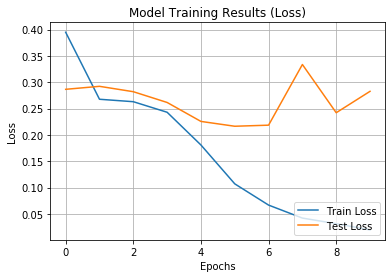

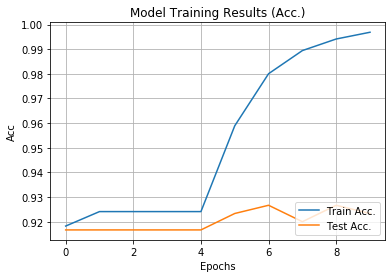

In [91]:

##### Loss #####
# Get training results
history_dict = history.history
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

# Plot training results
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Show plot
plt.title('Model Training Results (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Accuracy #####
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results (Acc.)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()

In [93]:

# prediction example
from scipy import stats
example = X_train[0]
corresponding_output = y_train[0]

print("Sentence: \n",
      example, "\n")
ids = sentence_to_word_ids(example, word_to_index_dict)[0]
print("Corresponding ids: \n",
      ids, "\n")
predictions = np.amin(model_rnn.predict(ids), axis=0)
print("Corresponding predictions: \n",
      predictions, "\n")
print("Final prediction: \n", 
      le_y.inverse_transform(stats.mode(predictions)[0].astype(int))[0], "\n")
print("Actual categorization: \n", 
     list(le_y.classes_)[oe_y.inverse_transform([corresponding_output])[0][0]])

Sentence: 
 the best line i've ever overheard at   hour: bitch, i'm gangster strong! #dc 

Corresponding ids: 
 [0, 254, 331, 41, 57, 37138, 661, 25881, 22, 1152, 45, 30619, 1, 41, 57, 1993, 16650, 562, 805, 2749, 8038] 

Corresponding predictions: 
 [0.39658698 0.19691852] 

Final prediction: 
 0 

Actual categorization: 
 0
